In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
%matplotlib inline
colors = sns.color_palette('Set1', 9)

In [3]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as gmm
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('Player_Data.csv')
ocols = [x for x in df.columns if x.startswith('o_')]
dcols = [x for x in df.columns if x.startswith('d_')]

# Get the columns to perform K-means on
Xo = df[ocols].values
Xd = df[dcols].values

# Weight offense and defense columns
# o_weight = .5
# d_weight = (1-o_weight)/o_weight * len(ocols)/len(dcols)

# Normalize values to 0 mean and 1 standard deviation
Xo_norm = StandardScaler().fit_transform(Xo)
Xd_norm = StandardScaler().fit_transform(Xd)

# for i in d_idx:
#     X_norm[:,i] *= d_weight

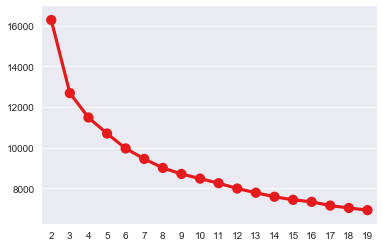

In [49]:
def elbow(k_max, X):
    elbow = {}
    for k in range(2,k_max):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        elbow[k] = kmeans.inertia_
    ax = sns.pointplot(x=list(elbow.keys()), y=list(elbow.values()), color=colors[0])

elbow(20, Xo_norm)

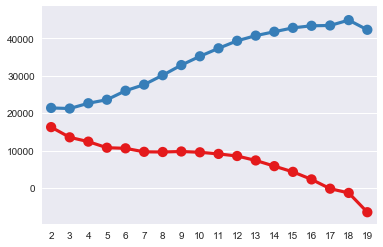

In [50]:
def aicBic(k_max, X):
    aic = {}
    bic = {}
    for k in range(2,k_max):
        gm = gmm(n_components=k, random_state=0).fit(X)
        aic[k] = gm.aic(X)
        bic[k] = gm.bic(X)
    ax = sns.pointplot(x=list(aic.keys()), y=list(aic.values()), color=colors[0])
    ax = sns.pointplot(x=list(bic.keys()), y=list(bic.values()), color=colors[1])
aicBic(20, Xo_norm)

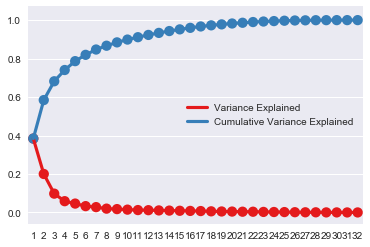

In [51]:
from sklearn.decomposition import PCA

def pcaDF(X):
    f, ax = plt.subplots(1, 1)
    n = len(X[0])
    pca = PCA(n_components=n, random_state=0)
    cols = ['PC'+str(x+1) for x in range(n)]
    dfpca = pd.DataFrame(pca.fit_transform(X), columns=cols)
    
    sns.pointplot(y=pca.explained_variance_ratio_,
                x=[x for x in range(1,n+1)], color=colors[0],
                  ax=ax)
    sns.pointplot(y=np.cumsum(pca.explained_variance_ratio_),
                  x=[x for x in range(1,n+1)], color=colors[1],
                  ax=ax)
    
    ax.legend(
        handles=ax.lines[::len(pca.explained_variance_ratio_)+1],
              labels=["Variance Explained","Cumulative Variance Explained"])
    return dfpca

dfpca = pcaDF(Xo_norm)

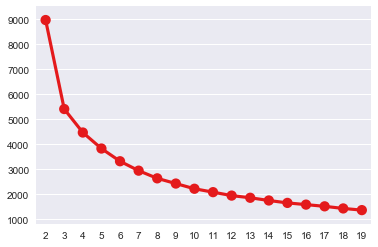

In [56]:
elbow(20, dfpca[['PC1', 'PC2', 'PC3']].values)

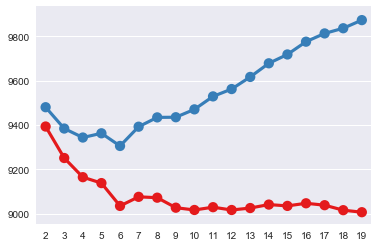

In [57]:
aicBic(20, dfpca[['PC1', 'PC2', 'PC3']].values)

0.323121732315


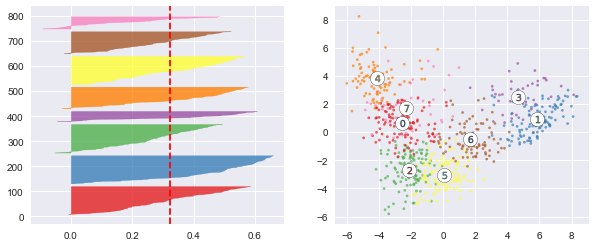

In [69]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

def silhouette(k, X):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    sil_av = silhouette_score(X, kmeans.labels_)
    print(sil_av)
    sil_samp = silhouette_samples(X, kmeans.labels_)
#     ax = sns.pointplot(x=list(elbow.keys()), y=list(elbow.values()), color=colors[0])
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    y_lower = 10
    c_dict = {}
    for i in range(k):
        sil_vals = sil_samp[kmeans.labels_ == i]
        sil_vals.sort()
        clust_size = sil_vals.shape[0]
        y_upper = y_lower + clust_size
        color = colors[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, sil_vals, facecolor=color,
                         edgecolor=color, alpha=.78)
        y_lower = y_upper + 10
        c_dict[i] = colors[i]
    ax1.axvline(x=sil_av, color="red", linestyle="--")

    centers = kmeans.cluster_centers_
    colors2 = [colors[x] for x in kmeans.labels_]
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors2, edgecolor='k')
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

silhouette(8, dfpca[['PC1', 'PC2', 'PC3']].values)

0.26065197652


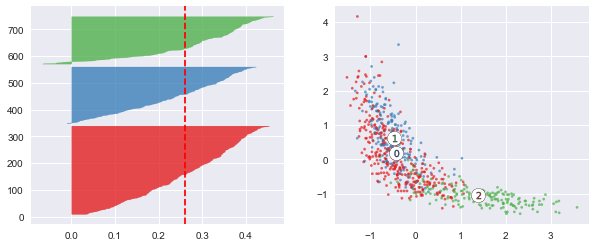

In [80]:
silhouette(3, Xo_norm)

In [111]:
def kmeansPlayersPCA(dfpca, df_orig, n_clusters, n_pc):
    X = dfpca.iloc[:, 0:n_pc].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    dfpca['Cluster'] = kmeans.labels_
    df_orig['PCA_Cluster'] = kmeans.labels_
    centers = kmeans.cluster_centers_
#     dist = 0
    df_orig['Dist'] = 0
    for i in range(n_pc):
        df_orig['Dist'] = df_orig['Dist'] + dfpca.apply(lambda x:
                                                        (x[i] - centers[int(x['Cluster'])][i])**2,
                                                        axis=1)
    dfpca.drop(['Cluster'], inplace=True, axis=1)
    print(df_orig.groupby('PCA_Cluster').count()['Dist'])
    print(df_orig.groupby(['PCA_Cluster', 'P']).count()['Dist'])
    print(df_orig.groupby('PCA_Cluster').mean()['Dist'])
    print(df_orig.groupby('PCA_Cluster').mean()[ocols])
    print(df_orig.loc[df_orig.sort_values('Dist',
                                            ascending=False).groupby('PCA_Cluster').head().index,
                 ['DISPLAY_FIRST_LAST',
                  'season', 'PCA_Cluster', 'Dist']
                ].sort_values('PCA_Cluster'))
    
    return centers
    
centers = kmeansPlayersPCA(dfpca, df, 8, 3)

PCA_Cluster
0    112
1    113
2    115
3     42
4     87
5    113
6     88
7     50
Name: Dist, dtype: int64
PCA_Cluster  P  
0            F        6
             G      100
             G-F      6
1            C       62
             F       30
             F-C     20
             G-F      1
2            F       23
             G       73
             G-F     19
3            C       17
             F       13
             F-C     12
4            F        3
             G       84
5            F       80
             F-C      1
             G       18
             G-F     14
6            C       11
             F       58
             F-C     15
             G-F      4
7            F       14
             G       22
             G-F     14
Name: Dist, dtype: int64
PCA_Cluster
0    2.987499
1    4.001590
2    3.331612
3    5.612226
4    3.915172
5    2.426119
6    3.687515
7    5.907614
Name: Dist, dtype: float64
             o_OREB_CHANCES  o_AVG_OREB_DIST  o_PULL_UP_FG3A  \
PCA_Cluste

In [93]:
def gmmPlayersPCA(dfpca, df_orig, n_clusters, n_pc):
    X = dfpca.iloc[:, 0:n_pc].values
    gm = gmm(n_components=n_clusters, random_state=0).fit(X)
    dfpca['Cluster'] = gm.predict(X)
    df_orig['PCA_Cluster'] = gm.predict(X)
    centers = gm.means_
    df_orig['Dist'] = 0
    for i in range(n_pc):
        df_orig['Dist'] = df_orig['Dist'] + dfpca.apply(lambda x:
                                                        (x[i] - centers[int(x['Cluster'])][i])**2,
                                                        axis=1)
    dfpca.drop(['Cluster'], inplace=True, axis=1)
    print(df_orig.groupby('PCA_Cluster').count()['Dist'])
    print(df_orig.groupby(['PCA_Cluster', 'P']).count()['Dist'])
    print(df_orig.groupby('PCA_Cluster').mean()['Dist'])
    print(df_orig.groupby('PCA_Cluster').mean()[ocols])
    print(df_orig.loc[df_orig.sort_values('Dist',
                                            ascending=False).groupby('PCA_Cluster').head().index,
                 ['DISPLAY_FIRST_LAST',
                  'season', 'PCA_Cluster', 'Dist']
                ].sort_values('PCA_Cluster'))
    
    return centers
    
centers = gmmPlayersPCA(dfpca, df, 9, 3)

PCA_Cluster
0     85
1     59
2    101
3    107
4    134
5     39
6     60
7     81
8     54
Name: Dist, dtype: int64
PCA_Cluster  P  
0            F      72
             G       5
             G-F     8
1            G      59
2            C      62
             F      21
             F-C    18
3            C      13
             F      73
             F-C    16
             G-F     5
4            F      28
             F-C     1
             G      79
             G-F    26
5            C      14
             F      12
             F-C    13
6            C       1
             F      12
             G      37
             G-F    10
7            G      80
             G-F     1
8            F       9
             G      37
             G-F     8
Name: Dist, dtype: int64
PCA_Cluster
0    2.161879
1    2.662806
2    3.660150
3    5.136007
4    3.058179
5    5.083646
6    8.067440
7    2.532809
8    4.199950
Name: Dist, dtype: float64
             o_OREB_CHANCES  o_AVG_OREB_DIST  o_PULL_U

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


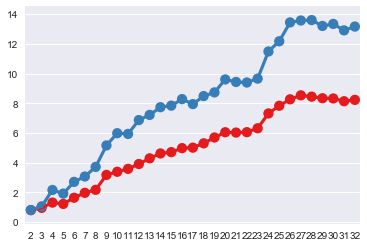

In [83]:
from sklearn.decomposition import FastICA as ICA

def elbowICA(X):
    elbow_all = {}
    elbow_top = {}
    n = len(X[0])
    for k in range(2,n+1):
#     for k in range(2, 5):
        df = pd.DataFrame(ICA(n_components=k, random_state=0).fit_transform(X))
        dfkurt = df.kurt(axis=0)
        elbow_all[k] = dfkurt.abs().mean()
        elbow_top[k] = dfkurt.abs().sort_values().iloc[int(k/2):].mean()
    ax = sns.pointplot(x=list(elbow_all.keys()), y=list(elbow_all.values()), color=colors[0])
    ax = sns.pointplot(x=list(elbow_top.keys()), y=list(elbow_top.values()), color=colors[1])

elbowICA(Xo_norm)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


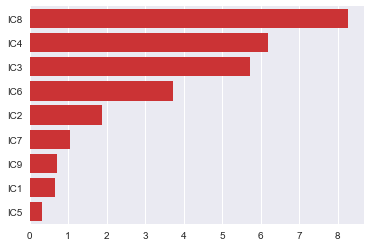

In [107]:
def icaDF(X, n):
    ica = ICA(n_components=n, random_state=0)
    cols = ['IC'+str(x+1) for x in range(n)]
    dfica = pd.DataFrame(ica.fit_transform(X), columns=cols)
    dfica = dfica[dfica.kurt(axis=0).abs().sort_values(ascending=False).index]
    sns.barplot(x=dfica.kurt(axis=0).abs().sort_values(ascending=False), y=dfica.columns,
                color=colors[0])
    dfica = dfica[dfica.kurt(axis=0).abs().sort_values(ascending=False).iloc[:-int(n/2)].index]
    
    return dfica

dfica = icaDF(Xo_norm, 9)

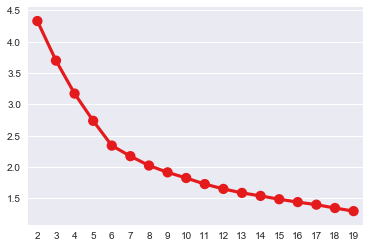

In [108]:
elbow(20, dfica.values)

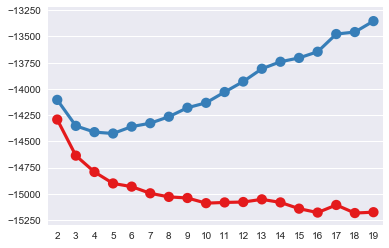

In [109]:
aicBic(20, dfica.values)

PCA_Cluster
0    357
1    124
2     53
3     51
4     64
5     71
Name: Dist, dtype: int64
PCA_Cluster  P  
0            C       39
             F      141
             F-C     11
             G      136
             G-F     30
1            F       14
             F-C      1
             G       91
             G-F     18
2            C        1
             F       12
             G       37
             G-F      3
3            C       28
             F        9
             F-C     13
             G-F      1
4            C        5
             F       20
             F-C      3
             G       31
             G-F      5
5            C       17
             F       31
             F-C     20
             G        2
             G-F      1
Name: Dist, dtype: int64
PCA_Cluster
0    0.002179
1    0.003781
2    0.006872
3    0.005132
4    0.002964
5    0.003959
Name: Dist, dtype: float64
             o_OREB_CHANCES  o_AVG_OREB_DIST  o_PULL_UP_FG3A  \
PCA_Cluster                     

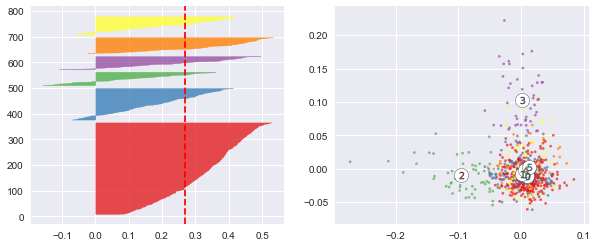

In [110]:
centers = kmeansPlayersPCA(dfica, df, 6, len(dfica.columns))
centers = gmmPlayersPCA(dfica, df, 5, len(dfica.columns))
silhouette(6, dfica.values)

In [42]:
def groupPlot(x, y, k, df):
    df['Cluster'] = KMeans(n_clusters=k,
                         random_state=0).fit(X_norm).predict(X_norm)
    sns.lmplot(x, y, data=df, hue = 'Cluster', fit_reg=False,
#                scatter_kws={'alpha':0.7}
              )
groupPlot('AVG_SEC_PER_TOUCH', 'Isolation_oPoss', 10, df)

KeyError: "['AVG_SEC_PER_TOUCH' 'Isolation_oPoss'] not in index"

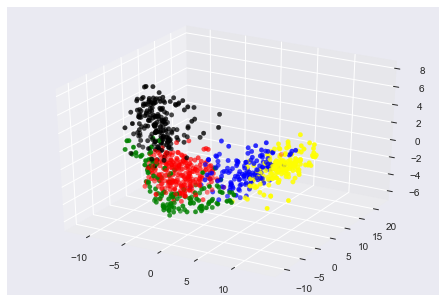

In [60]:
from mpl_toolkits.mplot3d import Axes3D

def plot3D(x, y, z, k, df):
    fig = plt.figure()
    ax = Axes3D(fig)
    df['Cluster'] = KMeans(n_clusters=k,
                         random_state=0).fit(X_norm).predict(X_norm)
    colors = {0:'red', 1:'blue', 2:'yellow', 3:'black', 4:'green'}
    ax.scatter(df[x].values,
               df[y].values,
               df[z].values, c = df['Cluster'].apply(lambda x: colors[x]))
plot3D('PC1', 'PC2', 'PC3', 5, dfpca)

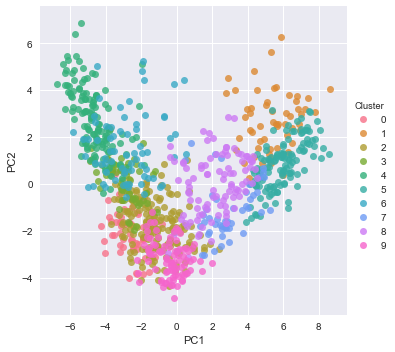

In [254]:
groupPlot('PC1', 'PC2', 10, dfpca)